In [20]:
from load_results import load_result_dataset
import pandas as pd

pn1 = 'full_fine_tuning_50epochs_edge_paper_final2'
pn2 = 'full_fine_tuning_50epochs_paper_final2'
final_data1 = load_result_dataset(pn1, pn2)
final_data1 = [{**d, 'ft_strategy': 'FFT (50 epochs)'} for d in final_data1]
df1 = pd.DataFrame(final_data1)

pn1 = 'full_fine_tuning_5epochs_edge_article1'
pn2 = 'full_fine_tuning_5epochs_article1'
final_data2 = load_result_dataset(pn1, pn2)
final_data2 = [{**d, 'ft_strategy': 'FFT (5 epochs)'} for d in final_data2]
df2 = pd.DataFrame(final_data2)

pn1 = 'linearprobe_50epochs_edge_paper_final2'
pn2 = 'linearprobe_50epochs_paper_final2'
final_data3 = load_result_dataset(pn1, pn2)
final_data3 = [{**d, 'ft_strategy': 'LP (50 epochs)'} for d in final_data3]
df3 = pd.DataFrame(final_data3)

df = pd.concat([ df1, df2, df3 ], axis=0, ignore_index=True) 

final_data = []
final_data.extend(final_data1)
final_data.extend(final_data2)
final_data.extend(final_data3)

../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion_aesthetic-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/CLIP-convnext_base_w-laion2B-s13B-b82K_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/deit_small_patch16_224.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/robust_resnet50_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/vit_small_patch16_224.augreg_in21k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/convnext_base.fb_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/resnet50.a1_in1k_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_paper_final2/robust_vit_base_patch16_224_uc-merced-land-use-dataset_TRADES_v2.pkl
../results/full_fine_tuning_50epochs_

In [21]:
df = pd.DataFrame(final_data)
for arch_size in ('small', 'medium', 'large'):
    df_curr = df[ df.model_size == arch_size ]
    nan_percentage = (df_curr.isna().sum().sum() / df_curr.size) * 100
    print("Percentage of NaN values, for {} architecture: {}".format(arch_size, nan_percentage) )

Percentage of NaN values, for small architecture: 0.2334267040149393
Percentage of NaN values, for medium architecture: 0.0
Percentage of NaN values, for large architecture: 0.09077705156136529


In [22]:
metrics = [ 'clean_acc', 'Linf_acc', 'L2_acc', 'L1_acc', 'common_acc' ]

for metric in metrics:
    df[f'{metric}_borda_rank'] = df[metric].rank(ascending=False, method='min')

# Now sum the borda ranks
borda_rank_cols = [f'{metric}_borda_rank' for metric in metrics]
df['total_borda_rank'] = df[borda_rank_cols].sum(axis=1)

# min_rank = df['total_borda_rank'].min()
# max_rank = df['total_borda_rank'].max()

# df['normalized_total_borda_rank'] = (df['total_borda_rank'] - min_rank) / (max_rank - min_rank)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
df['volume_pre_training_data_scaled'] = scaler.fit_transform(df[['volume_pre_training_data']])

# Features that define a unique configuration
group_cols = [
    'ft_strategy',
    'model_type',
    'model_size',
    'loss_function',
    'pre_training_dataset',
    'volume_pre_training_data_scaled',
    'pre_training_strategy' ]

# Metrics to sum over datasets
metrics_cols = ['sum', 'geom', 'total_borda_rank']

# Group by configuration and sum the metrics
grouped_df = df.groupby(group_cols, as_index=False)[metrics_cols].sum()

KeyError: "Columns not found: 'total_borda_rank'"

In [4]:
df.to_csv("global_results.csv")

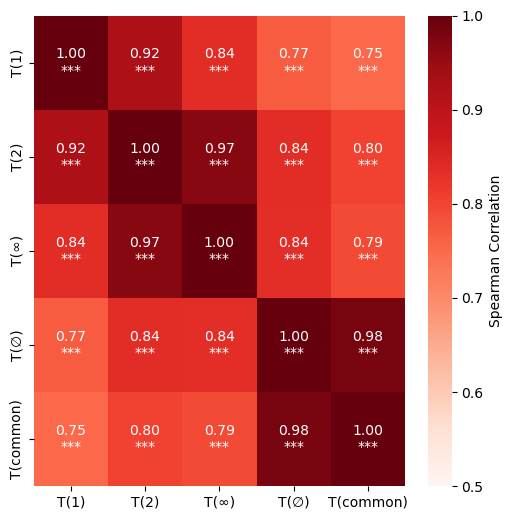

In [12]:
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


fft_50_df = df[df["ft_strategy"] == "FFT (50 epochs)"]

# Select only the relevant accuracy columns
metrics = ["L1_acc", "L2_acc", "Linf_acc", "common_acc", "clean_acc"]
fft_50_metrics = fft_50_df[metrics]

# Drop rows with any missing values in selected metrics
fft_50_metrics_clean = fft_50_metrics.dropna()

# Compute correlation matrix
correlation_matrix = fft_50_metrics_clean.corr(method='spearman')

metrics = [ "L1_acc", "L2_acc", "Linf_acc", "common_acc", "clean_acc" ]

# Compute Spearman rank correlations and corresponding p-values
corr_matrix = np.zeros((len(metrics), len(metrics)))
pval_matrix = np.zeros((len(metrics), len(metrics)))

for i, m1 in enumerate(metrics):
    for j, m2 in enumerate(metrics):
        corr, pval = stats.spearmanr(fft_50_metrics_clean[m1], fft_50_metrics_clean[m2])
        corr_matrix[i, j] = corr
        pval_matrix[i, j] = pval

# Create annotations with correlation and p-value
annotations = np.empty_like(corr_matrix, dtype=object)
for i in range(len(metrics)):
    for j in range(len(metrics)):
        annotations[i, j] = f"{corr_matrix[i, j]:.2f}\n(p={pval_matrix[i, j]:.2g})"

# Create annotations with correlation and asterisk significance levels
def pval_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

annotations_stars = np.empty_like(corr_matrix, dtype=object)
for i in range(len(metrics)):
    for j in range(len(metrics)):
        stars = pval_to_stars(pval_matrix[i, j])
        annotations_stars[i, j] = f"{corr_matrix[i, j]:.2f}\n{stars}"

# Plot 500x500 version with significance stars
custom_labels = [r"T(1)", r"T(2)", r"T(∞)", r"T(∅)", r"T(common)"]

# Plot 500x500 version with custom axis labels
plt.figure(figsize=(5, 5), dpi=100)

sns.heatmap(
    corr_matrix,
    annot=annotations_stars,
    fmt='',
    xticklabels=custom_labels,
    yticklabels=custom_labels,
    cmap='Reds',
    vmin=0.5,
    vmax=1.0,
    cbar_kws={'label': 'Spearman Correlation'}
)

plt.tight_layout(pad=0)

output_path_final = "./paper_figures/fft50_spearman_heatmap_red_500px_stars_custom_labels.png"
plt.savefig(output_path_final, bbox_inches='tight', dpi=100)
plt.show()




In [86]:
# Recompute correlation matrices using Spearman correlation

# Helper to compute correlation matrix with Spearman
def compute_spearman_corr(data):
    return data[['clean_acc', 'Linf_acc', 'L2_acc', 'L1_acc', 'common_acc']].corr(method='spearman')

# Global Spearman correlation matrix
global_spearman_corr = compute_spearman_corr(fft_df)

# Grouped Spearman correlation matrices
spearman_by_loss = {loss: compute_spearman_corr(sub_df) for loss, sub_df in fft_df.groupby("loss_function")}
spearman_by_size = {size: compute_spearman_corr(sub_df) for size, sub_df in fft_df.groupby("model_size")}
spearman_by_type = {mtype: compute_spearman_corr(sub_df) for mtype, sub_df in fft_df.groupby("model_type")}

# Compute summary metrics on Spearman correlations
global_spearman_summary = pd.DataFrame({
    "Mean Absolute Correlation": [mean_absolute_correlation(global_spearman_corr)],
    "Off-diagonal Frobenius Norm": [offdiag_frobenius_norm(global_spearman_corr)],
    "Average Pairwise R²": [avg_pairwise_r2(global_spearman_corr)]
}, index=["Global (Spearman)"])

# Grouped summaries
loss_spearman_summary = summarize_correlation_metrics(spearman_by_loss)
size_spearman_summary = summarize_correlation_metrics(spearman_by_size)
type_spearman_summary = summarize_correlation_metrics(spearman_by_type)

# Concatenate and display
all_spearman_summary = pd.concat([global_spearman_summary, loss_spearman_summary, size_spearman_summary, type_spearman_summary])
all_spearman_summary = all_spearman_summary.round(3)
# Convert the summary DataFrame to a LaTeX table
latex_table = all_spearman_summary.to_latex(index=True, caption="Spearman Correlation Summary Across Threat Models", label="tab:spearman_corr", column_format="lccc")

# Rename columns for more compact LaTeX-friendly names
# Reformat the LaTeX code generation to avoid invalid nesting and Overleaf issues

# Rename columns for compact display
compact_table = all_spearman_summary.rename(columns={
    "Mean Absolute Correlation": "Mean Abs. Corr.",
    "Off-diagonal Frobenius Norm": "Off-diag. Frobenius Norm",
    "Average Pairwise R²": "Avg. Pairwise R2"
})

# Generate the core LaTeX table body (without outer table/resizebox)
latex_core = compact_table.to_latex(index=True, escape=False, header=True)

# Remove the \begin{table} and \end{table} parts and keep only tabular body
latex_core_lines = latex_core.splitlines()
tabular_start = next(i for i, line in enumerate(latex_core_lines) if line.startswith(r"\begin{tabular}"))
tabular_end = next(i for i, line in enumerate(latex_core_lines) if line.startswith(r"\end{tabular}")) + 1
tabular_content = "\n".join(latex_core_lines[tabular_start:tabular_end])

# Now wrap it correctly for Overleaf
corrected_latex = f"""
\\begin{{table}}[h!]
\\centering
\\caption{{Spearman Correlation Summary Across Threat Models}}
\\label{{tab:spearman_corr}}
\\resizebox{{0.33\\textwidth}}{{!}}{{%
{tabular_content}
}}
\\end{{table}}
"""

file_path = f"./latex_tables/correlation_matrix.tex"
with open(file_path, "w") as f:
    f.write(corrected_latex)



/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_26610/2110209006.py:31: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_26610/2110209006.py:44: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
# df['volume_pre_training_data_scaled'] = scaler.fit_transform(df[['volume_pre_training_data']])



In [36]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr

# Features to use
features = [
    'model_type',
    'model_size',
    'loss_function',
    # 'pre_training_dataset',
    # 'volume_pre_training_data_scaled',
    'pre_training_strategy',
]
target = 'sum' #'normalized_total_borda_rank'

# Loop over each ft_strategy
for ft_strategy in [ "FFT (50 epochs)",]: #  "FFT (5 epochs)", "LP (50 epochs)" 
    print(f"\n================ Regression and Pearson correlation for {ft_strategy} ================\n")
    
    # Subset
    #sub_df = grouped_df[grouped_df['ft_strategy'] == ft_strategy]
    sub_df = grouped_df[grouped_df['ft_strategy'] == ft_strategy].copy()

    scaler = MinMaxScaler()
    sub_df['normalized_total_borda_rank'] = scaler.fit_transform(sub_df[['total_borda_rank']])
        
    # Encode categorical variables
    base_encoded = pd.get_dummies(sub_df[features], drop_first=True)
    
    # Start with base features
    X = base_encoded.copy()
    
    # Manually add only selected interactions
    # model_type × pre_training_strategy
    model_type_cols = [col for col in base_encoded.columns if col.startswith('model_type_')]
    pretrain_strategy_cols = [col for col in base_encoded.columns if col.startswith('pre_training_strategy_')]
    loss_function_cols = [col for col in base_encoded.columns if col.startswith('loss_function_')]

    # for mt in model_type_cols:
    #     for ps in pretrain_strategy_cols:
    #         X[f"{mt} x {ps}"] = base_encoded[mt] * base_encoded[ps]
    
    # model_type × loss_function
    
    # for mt in model_type_cols:
    #     for lf in loss_function_cols:
    #         X[f"{mt} x {lf}"] = base_encoded[mt] * base_encoded[lf]
    
    # pre_training_strategy x loss_function
    # for pt in pretrain_strategy_cols:
    #     for lf in loss_function_cols:
    #         X[f"{pt} x {lf}"] = base_encoded[pt] * base_encoded[lf]
    
    # model_size × loss_function
    # for ms in model_size_cols:
    #     for lf in loss_function_cols:
    #         X[f"{ms} x {lf}"] = base_encoded[ms] * base_encoded[lf]
    
    # Target variable
    y = sub_df[target]
    
    # Add constant
    X = sm.add_constant(X)

    # Regression
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Pearson correlation for each **base feature** (not interaction terms)
    print("\n--- Pearson correlation for each base feature ---")
    for col in base_encoded.columns:
        corr, pval = pearsonr(base_encoded[col], y)
        print(f"Feature: {col:40s} | Pearson r = {corr:.3f}, p-value = {pval:.3f}")




================ Regression and Pearson correlation for FFT (50 epochs) ================

                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     3.199
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00375
Time:                        23:40:35   Log-Likelihood:                -182.61
No. Observations:                  62   AIC:                             385.2
Df Residuals:                      52   BIC:                             406.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]


In [34]:
grouped_df

,ft_strategy,model_type,model_size,loss_function,pre_training_dataset,volume_pre_training_data_scaled,pre_training_strategy,sum,geom,total_borda_rank
0,FFT (5 epochs),fully attention,large,CLASSIC_AT,in1k,0.000000,self-supervised,1.527381,5.856400e-11,24945.0
1,FFT (5 epochs),fully attention,large,CLASSIC_AT,in1k,0.000000,supervised,2.715952,6.857410e-03,21327.0
2,FFT (5 epochs),fully attention,large,CLASSIC_AT,in1k,0.000000,supervised (robust),1.418476,4.786837e-05,23304.0
3,FFT (5 epochs),fully attention,large,CLASSIC_AT,in22k,0.005546,self-supervised,1.999667,3.226714e-05,23148.0
4,FFT (5 epochs),fully attention,large,CLASSIC_AT,in22k,0.005546,supervised,0.785127,8.681801e-06,26236.0
...,...,...,...,...,...,...,...,...,...,...
181,LP (50 epochs),hybrid,large,TRADES_v2,in12k+in1k,0.003864,supervised,7.091619,0.000000e+00,18391.0
182,LP (50 epochs),hybrid,medium,CLASSIC_AT,in1k,0.000000,supervised,4.020016,0.000000e+00,22120.0
183,LP (50 epochs),hybrid,medium,TRADES_v2,in1k,0.000000,supervised,5.377381,0.000000e+00,19908.0
184,LP (50 epochs),hybrid,small,CLASSIC_AT,in1k,0.000000,supervised,1.895190,0.000000e+00,83156.0


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import shap
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Features to use
features = [
    'model_type',
    'model_size',
    'loss_function',
    'pre_training_dataset',
    'volume_pre_training_data_scaled',
    'pre_training_strategy',
]
target = 'normalized_total_borda_rank'

# Loop over each ft_strategy
for ft_strategy in [ "LP (50 epochs)" ]: #
    print(f"\n================ Random Forest Regression, Feature Importance, SHAP, and Correlations for {ft_strategy} ================\n")
    
    # Subset
    sub_df = df[df['ft_strategy'] == ft_strategy]
    
    # Encode categorical variables
    base_encoded = pd.get_dummies(sub_df[features], drop_first=True)
    
    # Start with base features
    X = base_encoded.copy()
    
    # Manually add only selected interactions
    model_type_cols = [col for col in base_encoded.columns if col.startswith('model_type_')]
    pretrain_strategy_cols = [col for col in base_encoded.columns if col.startswith('pre_training_strategy_')]
    for mt in model_type_cols:
        for ps in pretrain_strategy_cols:
            X[f"{mt} x {ps}"] = base_encoded[mt] * base_encoded[ps]
    
    loss_function_cols = [col for col in base_encoded.columns if col.startswith('loss_function_')]
    for mt in model_type_cols:
        for lf in loss_function_cols:
            X[f"{mt} x {lf}"] = base_encoded[mt] * base_encoded[lf]
    
    model_size_cols = [col for col in base_encoded.columns if col.startswith('model_size_')]
    for ms in model_size_cols:
        for ps in pretrain_strategy_cols:
            X[f"{ms} x {ps}"] = base_encoded[ms] * base_encoded[ps]
    
    for ms in model_size_cols:
        for lf in loss_function_cols:
            X[f"{ms} x {lf}"] = base_encoded[ms] * base_encoded[lf]
    
    # Target variable
    y = sub_df[target]
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X, y)
    
    # Print R² (on training set)
    print(f"Training R² score: {rf.score(X, y):.3f}")
    
    # Extract feature importances
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X)
    
    # Aggregate SHAP importance
    shap_importance = pd.Series(shap_values.mean(axis=0), index=X.columns)
    
    # Initialize the combined importance dataframe
    combined_importance = pd.DataFrame({
        'RandomForest_FeatureImportance': feature_importances,
        'SHAP_Importance': shap_importance
    })
    
    # Compute Pearson and Spearman correlations for **base features only** (no interactions)
    pearson_corr = []
    pearson_pval = []
    spearman_corr = []
    spearman_pval = []
    
    for col in X.columns:  # not base_encoded.columns
        pearson_r, pearson_p = pearsonr(X[col], y)
        spearman_r, spearman_p = spearmanr(X[col], y)
        
        pearson_corr.append(pearson_r)
        pearson_pval.append(pearson_p)
        spearman_corr.append(spearman_r)
        spearman_pval.append(spearman_p)
    
    correlation_df = pd.DataFrame({
        'Pearson_r': pearson_corr,
        'Pearson_pval': pearson_pval,
        'Spearman_r': spearman_corr,
        'Spearman_pval': spearman_pval
    }, index=X.columns)
    
    # Merge correlation info into the combined importance table
    combined_importance = combined_importance.join(correlation_df, how='left')
    
    # Print the final combined table
    print("\n--- Combined Feature Importances and Correlations ---")

pd.set_option('display.float_format', '{:.4f}'.format)

combined_importance = combined_importance.round(4)
combined_importance = combined_importance.sort_values(by='RandomForest_FeatureImportance', ascending=True)  # or ascending=False
combined_importance


================ Random Forest Regression, Feature Importance, SHAP, and Correlations for LP (50 epochs) ================

Training R² score: 0.329

--- Combined Feature Importances and Correlations ---


/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/maximeheuillet/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,RandomForest_FeatureImportance,SHAP_Importance,Pearson_r,Pearson_pval,Spearman_r,Spearman_pval
model_size_medium x pre_training_strategy_supervised (robust),0.2469,0.0011,-0.3147,0.0000,-0.1983,0.0000
volume_pre_training_data_scaled,0.0989,0.0016,-0.1457,0.0014,-0.2486,0.0000
model_size_medium,0.0797,0.0002,-0.0179,0.6953,0.0358,0.4344
pre_training_dataset_in1k,0.0701,0.0014,0.1771,0.0001,0.2431,0.0000
model_type_fully convolutional x loss_function_TRADES_v2,0.0619,0.0001,-0.1682,0.0002,-0.1702,0.0002
loss_function_TRADES_v2,0.0578,-0.0001,-0.0908,0.0468,-0.1005,0.0276
model_type_fully convolutional,0.0450,-0.0002,-0.1645,0.0003,-0.1578,0.0005
pre_training_strategy_self-supervised,0.0367,-0.0015,0.1246,0.0063,0.1274,0.0052
model_size_small x pre_training_strategy_supervised,0.0342,-0.0005,0.2585,0.0000,0.2645,0.0000
model_type_fully convolutional x pre_training_strategy_supervised (robust),0.0329,-0.0012,-0.2183,0.0000,-0.1347,0.0031


In [8]:
import plotly.graph_objects as go
import pandas as pd

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import spearmanr
import numpy as np
from numpy.linalg import LinAlgError
from scipy.stats import linregress

import pandas as pd
from scipy.stats import spearmanr, pearsonr
from process_database import process_grouped_df, process_rankings,global_grouped_dataset


grouped_df = global_grouped_dataset(df,)
grouped_df = process_rankings(grouped_df)

grouped_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_df.columns]
grouped_df = grouped_df.reset_index()

grouped_df = grouped_df[["ft_strategy", "model_type", "model_size", "backbone", "loss_function", "TOTAL_score_sum"]]

results = []
for strategy in [ "FFT (50 epochs)", ]: # "FFT (5 epochs)", 'LP (50 epochs)'
    for size in ["small",]: # "medium", "large"

        res = grouped_df[
            (grouped_df.ft_strategy == strategy) # &
            #(grouped_df.model_size == size)
        ]

        q = res["TOTAL_score_sum"]

        # Compute quantiles
        quantiles = q.quantile([0.25, 0.5, 0.75, 0.90])
        labels = ['25%', '50%', '75%', '90%']
        counts = {}
        for label, thresh in zip(labels, quantiles):
            counts[label] = (q <= thresh).sum()
        # counts['min'] = 1
        # counts['max'] = 1

        stats = q.quantile([0.25, 0.5, 0.75, 0.90, ]).rename(index={0.25: '25%', 
                                                                            0.5: '50%', 
                                                                            0.75: '75%',
                                                                            0.90: '90%',})

        # Append min and max
        min_val = q.min()
        max_val = q.max()

        q_extended = pd.concat([stats, pd.Series({"min": min_val, "max": max_val})]).to_dict()
        q_extended['strategy'] = strategy
        #q_extended["size"] = size
        for key, count in counts.items():
            q_extended[f"{key}_count"] = count
        results.append( q_extended )


import pandas as pd
import plotly.express as px

# Create DataFrame
res = pd.DataFrame(results)

# Melt the DataFrame
df_long = res.melt(id_vars=['strategy', ], var_name='percentile', value_name='value') #'size'

# Define proper order
ordered_percentiles = ['min', '25%', '50%', '75%', '90%', 'max']
df_long['percentile'] = pd.Categorical(df_long['percentile'], categories=ordered_percentiles, ordered=True)

def get_count(row):
    colname = f"{row['percentile']}_count"
    # Get the count from the original df based on strategy & size
    subset = res[(res['strategy'] == row['strategy']) ] #& (res['size'] == row['size'])
    if colname in subset.columns:
        return int(subset[colname].values[0])
    else:
        return 'N/A'

df_long["hover_text"] = df_long.apply(
    lambda row: f"{row['strategy']} <br>{row['percentile']} = {row['value']:.2f}<br>n={get_count(row)}", #– {row['size']}
    axis=1
)

# ✅ Sort so lines connect in correct order
df_long = df_long.sort_values(by=['strategy',  'percentile']) #'size',

# Plot
fig = px.line(
    df_long,
    x='percentile',
    y='value',
    color='strategy',
    # line_dash='size',
    markers=True,
    labels={'value': 'Total Sum Score',
            'percentile': 'Quantile (by Total Sum Score)',},
    # title='Score Percentiles by Strategy and Model Size',
    category_orders={'percentile': ordered_percentiles}
)

import plotly.graph_objects as go

for i, row in df_long.iterrows():
    count_key = f"{row['percentile']}_count"
    try:
        count = res[
            (res['strategy'] == row['strategy']) #&
            # (res['size'] == row['size'])
        ][count_key].values[0]
        fig.add_annotation(
            x=row['percentile'],
            y=row['value'],
            text=f"n={count}",
            showarrow=False,
            font=dict(size=8),
            xanchor="left",
            yanchor="bottom"
        )
    except:
        pass

fig.update_layout(yaxis=dict(range=[0, 30]),)
fig.update_layout(
    width=450,
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis=dict(showgrid=True, gridcolor="lightgrey"),
    yaxis=dict(showgrid=True, gridcolor="lightgrey"),
    legend_title_text="Strategy / Architecture Size",

    legend=dict(
    x=0.05,
    y=1,
    xanchor='left',
    yanchor='top',
    font=dict(size=10),  # Increase font size
    bgcolor="rgba(255,255,255,0.5)",
    bordercolor="lightgrey",
    borderwidth=1,
    itemsizing="constant"  # 👈 Key to reduce spacing
)
)

fig.show()
# fig.write_image("./paper_figures/quantile_perf_improve.png", scale=3  )
    

In [13]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import spearmanr
import numpy as np
from numpy.linalg import LinAlgError
from scipy.stats import linregress

import pandas as pd
from scipy.stats import spearmanr, pearsonr
from process_database import process_grouped_df, process_rankings,global_grouped_dataset


grouped_df = global_grouped_dataset(df,)
grouped_df = process_rankings(grouped_df)
# Flatten the columns
grouped_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_df.columns]
grouped_df = grouped_df.reset_index()
sub_df = grouped_df[["ft_strategy", "model_type", "model_size", "backbone", "loss_function", "TOTAL_score_sum"]]

# ── 1.  Reshape: one row per backbone × loss_function, one column per project
pivot_df = sub_df.pivot_table(
    index=["backbone", "loss_function",  "model_type", "model_size",],
    columns="ft_strategy",
    values="TOTAL_score_sum"
).reset_index()

symbol_map = {"TRADES_v2": "diamond", "CLASSIC_AT": "star"}

color_palette = ["#E69F00", "#56B4E9",  "#009E73",  ] # "#009E73", "#F0E442", "#0072B2","#CC79A7", "#D55E00",
unique_sizes = pivot_df["model_size"].unique()
color_map = {size: color_palette[i % len(color_palette)] for i, size in enumerate(unique_sizes)}


for (x1,x2) in [ ("FFT (5 epochs)", "FFT (50 epochs)"), ("LP (50 epochs)", "FFT (50 epochs)") ]:

    # Global correlation
    pivot_df = pivot_df.fillna(0)
    x = pivot_df[x1]
    y = pivot_df[x2]
    r_global, p_global = spearmanr(x, y)
    try:
        # m_global, b_global = np.polyfit(x, y, 1)
        m_global, b_global, r, p, _ = linregress(x, y)
    except Exception as e:
        print(f"Warning: polyfit failed with error: {e}")
        m_global, b_global = 0, y.mean()  # or any safe fallback
    x_range = np.linspace(x.min(), x.max(), 100)

    # Base scatter plot
    fig = px.scatter(
        pivot_df,
        x=x1,
        y=x2,
        color="model_size",
        symbol="loss_function",
        symbol_map=symbol_map,
        color_discrete_map=color_map,
        labels={
            "full_fine_tuning_5epochs": "Fine-tuning (5 epochs)",
            "full_fine_tuning_50epochs": "Fine-tuning (50 epochs)",
            "linearprobe_50epochs": "Linear-probing (50 epochs)"
        },
        #title="Fine-Tuning Correlation (5 vs 50 Epochs)"
    )

    # Global black line
    fig.add_trace(go.Scatter(
        x=x_range,
        y=m_global * x_range + b_global,
        mode="lines",
        line=dict(color="black", dash="solid", width=2),
        name=f"Global (r={r_global:.2f}, p={p_global:.3f})"
    ))



    # Add per-group lines
    for model_size in pivot_df["model_size"].unique():
        for loss_function, style in zip(["TRADES_v2", "CLASSIC_AT"], ["solid", "dot"]):
            subset = pivot_df[(pivot_df["model_size"] == model_size) & (pivot_df["loss_function"] == loss_function)]
            if len(subset) >= 2:
                xg, yg = subset[x1], subset[x2]
                rg, pg = spearmanr(xg, yg)

                try:
                    mg, bg, r, p, _ = linregress(xg, yg)
                except Exception as e:
                    print(f"Warning: polyfit failed with error: {e}")
                    mg, bg = 0, yg.mean()  # or any safe fallback
                    
                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=mg * x_range + bg,
                    mode="lines",
                    line=dict(color=color_map[model_size], dash=style),
                    name=f"{model_size} – {loss_function} (r={rg:.2f}, p={pg:.3f})"
                ))

    fig.update_layout(yaxis=dict(range=[0, 20]),)
    fig.update_layout(xaxis=dict(range=[-0.25, 8.25]),)
    # Layout tweaks
    fig.update_traces(marker=dict(size=8, line=dict(width=0, color='DarkSlateGrey')))
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),  # remove all outer margins
        width=800, #if x1=='full_fine_tuning_5epochs' else 488 ,    # in pixels (~2.5 inches at 96 DPI)
        height=400,    # in pixels (~1.875 inches)
        plot_bgcolor="white",
        paper_bgcolor="white",
        xaxis=dict(showgrid=True, gridcolor="lightgrey"),
        yaxis=dict(showgrid=True, gridcolor="lightgrey"),
        legend_title_text="Legend",
        #showlegend = True if x1=='full_fine_tuning_5epochs' else False,

                    # Legend inside figure
        legend=dict(
                font=dict(size=12),
                y=0.85,           # optional: near the top
                bgcolor="rgba(255,255,255,1)",
                bordercolor="lightgrey",
                borderwidth=1
            )
    )

    fig.show()
    fig.write_image("./paper_figures/low_cost_proxy_{}.png".format(x1,x2), scale=3  )


In [15]:
import pandas as pd
from scipy.stats import fisher_exact
from process_database import process_grouped_df, process_rankings
from load_results import load_result_dataset

# Collector for odds ratios and p-values
results = []
# group = 'model_type'
# group = 'pre_training_strategy'
group = 'model_size'

grouped_df = process_grouped_df(final_data)
grouped_df = process_rankings(grouped_df)
odds_df = grouped_df['TOTAL'].reset_index()
# Unique ID for observation
index_cols = ['backbone', 'pre_training_strategy', 'model_type', 'model_size', 'ft_strategy']
score_col = "score_sum"

for cond in set(odds_df[group] ):

        subset = odds_df[ odds_df[group] == cond ]

        pivot = subset.pivot_table(
                        index=index_cols,
                        columns="loss_function",
                        values=score_col ).dropna()
        
                # Pairwise TRADES vs CLASSIC
        pivot["winner"] = pivot.apply(
                        lambda row: "TRADES" if row["TRADES_v2"] > row["CLASSIC_AT"]
                        else "CLASSIC" if row["TRADES_v2"] < row["CLASSIC_AT"]
                        else "TIE",
                        axis=1
                        )
        
        # wins = pivot[pivot["winner"] != "TIE"]
        # trades_wins = (wins["winner"] == "TRADES").sum()
        # classic_wins = (wins["winner"] == "CLASSIC").sum()

        # table = [[trades_wins, classic_wins], [classic_wins, trades_wins]]
        #         # table = [[trades_wins, classic_wins], [classic_wins, trades_wins]]
        # odds_ratio, p_value = fisher_exact(table)

        # results.append({
        #         # "fts": fts,
        #         "cond": cond,
        #         "trades_wins": trades_wins,
        #         "classic_wins": classic_wins,
        #         "odds_ratio": odds_ratio,
        #         "p_value": p_value })
        
        
        for fts in [ "FFT (50 epochs)", "FFT (5 epochs)", "LP (50 epochs)" ]:
                 
                pivot2 = pivot.reset_index()
                pivot2 = pivot2[ pivot2.ft_strategy == fts ]

                wins = pivot2[pivot2["winner"] != "TIE"]
                trades_wins = (wins["winner"] == "TRADES").sum()
                classic_wins = (wins["winner"] == "CLASSIC").sum()

                table = [[trades_wins, classic_wins], [classic_wins, trades_wins]]
                # table = [[trades_wins, classic_wins], [classic_wins, trades_wins]]
                odds_ratio, p_value = fisher_exact(table)

                # Collect result
                results.append({
                                "fts": fts,
                                "cond": cond,
                                "trades_wins": trades_wins,
                                "classic_wins": classic_wins,
                                "odds_ratio": odds_ratio,
                                "p_value": p_value
                                })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df

Percentage of NaN values: 0.08%


,fts,cond,trades_wins,classic_wins,odds_ratio,p_value
0,FFT (50 epochs),medium,11,4,7.562500,2.683773e-02
1,FFT (5 epochs),medium,7,8,0.765625,1.000000e+00
2,LP (50 epochs),medium,10,5,4.000000,1.431110e-01
3,FFT (50 epochs),large,18,0,inf,2.203824e-10
4,FFT (5 epochs),large,15,3,25.000000,1.519735e-04
5,LP (50 epochs),large,15,3,25.000000,1.519735e-04
6,FFT (50 epochs),small,5,2,6.250000,2.861305e-01
7,FFT (5 epochs),small,4,3,1.777778,1.000000e+00
8,LP (50 epochs),small,3,4,0.562500,1.000000e+00


In [16]:
import plotly.express as px
import pandas as pd
import numpy as np

# Add sample size column
results_df["sample_size"] = results_df["trades_wins"] + results_df["classic_wins"]

# 3)  pretty text – use “∞” for the truly infinite ones
def fmt_or(x):
    if np.isinf(x):
        return "∞"
    return f"{x:.2f}" if x % 1 else f"{int(x)}"

results_df["text_label"] = (
    results_df.apply(
        lambda r: (
            f"{fmt_or(r['odds_ratio'])}"
            f"<br>(p={r['p_value']:.3f})"
            #f"<br>n={r['sample_size']}"
        ),
        axis=1,
    )
)

# cap infinite values at 10 % above the largest finite OR
finite_mask = np.isfinite(results_df["odds_ratio"])
finite_max  = results_df.loc[finite_mask, "odds_ratio"].max()
cap_value   = finite_max * 1.10

results_df["odds_ratio2"] = results_df["odds_ratio"].replace([np.inf, -np.inf],
                                                             cap_value)

if group == "pre_training_strategy":
    label_map = {
        "self-supervised (multimodal)": "self-sup<br>(multimodal)",
        "supervised (robust)": "sup<br>(robust)",
        "supervised": "sup",
        "hybrid": "hybrid",
        "self-supervised": "self-sup"
    }

    results_df["cond"] = results_df["cond"].map(label_map)


# Color-blind-friendly palette (Color Universal Design, up to 8 categories)
color_blind_palette = [
    "#E69F00",  # orange
    "#56B4E9",  # blue
    "#CC79A7",  # pink
    "#0072B2",  # dark blue
    "#D55E00",  # vermillion
    "#009E73",  # green
    "#F0E442",  # yellow
    "#999999",  # gray
]

# Optional: Create a mapping from unique `fts` values to color
fts_unique = results_df["fts"].unique()
color_discrete_map = {
    fts: color_blind_palette[i % len(color_blind_palette)]
    for i, fts in enumerate(fts_unique)
}


fig = px.bar(
    results_df,
    x="cond",
    y="odds_ratio2",
    color="fts",
    barmode="group",
    text="text_label",
    labels={"cond": "{}".format(group), "odds_ratio2": "Odds Ratio", "fts": "Fine-Tuning Strategy"},
    color_discrete_map=color_discrete_map
)

# Update traces for text styling
fig.update_traces(
    textposition="outside",
    textangle=-90,
    textfont=dict(size=6),
    cliponaxis=False
)

fig.update_layout(
            margin=dict(l=0, r=0, t=40, b=0),  # remove all outer margins
            width=450,    # in pixels (~2.5 inches at 96 DPI)
            height=400,    # in pixels (~1.875 inches)
            yaxis_title="Odds Ratio",
            xaxis_title="{}".format(group),            
            # White background
            plot_bgcolor="white",
            paper_bgcolor="white",
            
            # Light grey grid
            xaxis=dict(showgrid=False, gridcolor="lightgrey"),
            yaxis=dict(showgrid=True, gridcolor="lightgrey"),
            uniformtext_minsize=8,
            uniformtext_mode='show',
            showlegend = True,
            
            # Legend inside figure
            legend=dict(
                font=dict(size=12),
                yanchor="top",
                xanchor="left",   # anchor point for x position
                x=0.5,           # move legend to the left side
                y=1.1,           # optional: near the top
                bgcolor="rgba(255,255,255,1)",
                bordercolor="lightgrey",
                borderwidth=1
            )
        )

fig.show()
fig.write_image("./paper_figures/oddsratio_TRADES_outperforms_{}.png".format(group), scale=3  )


In [17]:
import plotly.express as px
import pandas as pd

# Add sample size column
results_df["sample_size"] = results_df["trades_wins"] + results_df["classic_wins"]

# Format text label with odds ratio, p-value, and sample size
results_df["text_label"] = results_df.apply(
    lambda row: (
        f'{int(row["odds_ratio"])}' if row["odds_ratio"] == int(row["odds_ratio"]) 
        else f'{row["odds_ratio"]:.2f}'
    ) + f'<br>(p={row["p_value"]:.3f})<br>n={row["sample_size"]}',
    axis=1
)

# List of conditions to split by
conditions = ["model_type", "pre_training_strategy"]

for cond in conditions:
    # Group by condition + size + protocol
    grouped = results_df.groupby([cond, "size", "protocol"]).agg(
        trades_wins_sum=("trades_wins", "sum"),
        classic_wins_sum=("classic_wins", "sum")
    ).reset_index()
    
    # Compute odds ratio
    grouped["odds_ratio"] = (grouped["trades_wins_sum"] + 0.5) / (grouped["classic_wins_sum"] + 0.5)
    grouped["sample_size"] = grouped["trades_wins_sum"] + grouped["classic_wins_sum"]
    
    # You can add p-values here if needed; for now we'll omit for simplicity
    grouped["text_label"] = grouped.apply(
        lambda row: (
            f'{int(row["odds_ratio"])}' if row["odds_ratio"] == int(row["odds_ratio"]) 
            else f'{row["odds_ratio"]:.2f}'
        ) + f'<br>n={row["sample_size"]}',
        axis=1
    )
    
    unique_values = grouped[cond].unique()
    
    for val in unique_values:
        sub_df = grouped[grouped[cond] == val]
        
        fig = px.bar(
            sub_df,
            x="size",
            y="odds_ratio",
            color="protocol",
            barmode="group",
            text="text_label",
            labels={"size": "Model Size", "odds_ratio": "Odds Ratio"},
            title=f"TRADES vs Classic - Conditioned on {cond}: {val}"
        )

        fig.update_traces(
            textposition="outside",
            textangle=-90,
            textfont=dict(size=10),
            cliponaxis=False
        )

        fig.update_layout(
            margin=dict(l=0, r=0, t=30, b=0),
            width=450,
            height=400,
            yaxis_title="Odds Ratio",
            xaxis_title="Model Size",
            plot_bgcolor="white",
            paper_bgcolor="white",
            xaxis=dict(showgrid=False, gridcolor="lightgrey"),
            yaxis=dict(showgrid=True, gridcolor="lightgrey"),
            uniformtext_minsize=8,
            uniformtext_mode='show',
            legend=dict(
                font=dict(size=12),
                yanchor="top",
                xanchor="left",
                x=0.05,
                y=1.15,
                bgcolor="rgba(255,255,255,1)",
                bordercolor="lightgrey",
                borderwidth=1
            )
        )

        fig.show()
        fig.write_image(f"./paper_figures/oddsratio_TRADES_vs_classic_{cond}_{val}.png", scale=3)


OverflowError: cannot convert float infinity to integer

In [ ]:
from process_database import process_grouped_df, process_rankings, compute_odds_ratio_by_group
import pandas as pd
from io import StringIO

def fmt_entry(backbone, loss, rank):
    """
    Return a LaTeX-safe, two‑line cell:
      backbone, loss
      (GR: rank)
    Underscores are escaped.
    """
    backbone = backbone.replace('_', r'\_')
    loss     = loss.replace('_', r'\_')
    return (
        r'\makecell{'            # open
        f'{backbone}, {loss} \\\\ '   # first line
        r'\small (GR:'           # second line, smaller font if you like
        f'{rank})'               #   ↳ value
        r'}'                     # close
    )


final_data = pd.concat([ df1,df2,df3 ], axis=0, ignore_index=True) 

for setting in ('FFT (50 epochs)', 'FFT (5 epochs)', 'LP (50 epochs)' ): 

    result = []

    d = final_data[ final_data.ft_strategy == setting ]
    grouped_df = process_grouped_df(d)
    grouped_df = process_rankings(grouped_df)

    for size_id,size in [ (0,'small'), (1,'medium'), (2,'large') ]:

        copy = grouped_df.xs(size, level="model_size") #grouped_df[ grouped_df.model_size == size  ]
        
        remaining_columns = [ 'rank_borda',	'rank_geom', 'rank_sum', 'score_geom', 'score_sum', 'borda' ]
        filtered_df = copy.loc[:, ('TOTAL', remaining_columns)]
        filtered_df = filtered_df.reset_index()
        
        filtered_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in filtered_df.columns]
        filtered_df.columns = [ 'backbone', "backbone_name", 'loss', 'pre_training_strategy', 'model_type','ft_strategy', 'total Borda rank', 'total geom rank', 'total sum rank',  'total geom value', 'total sum value', 'total Borda value',   ]

        n_rows = filtered_df.shape[0]

        # top_k = int(np.ceil(0.33 * n_rows))  # top 10% as tier1
        # print(top_k)
        filtered_df = filtered_df.head(3)

        filtered_df = filtered_df.round(4)

        df_sorted = filtered_df.sort_values(by='total sum value', ascending=False).reset_index(drop=True)
        # print(df_sorted)

        result.append({
            'Size': size,
            'Gold (1st)': str(df_sorted['backbone_name'][0]) + ',' + df_sorted['loss'][0] + ' ' + '\\(GR:' + str(df_sorted['total sum rank'][0]) + ')',
            'Silver (2nd)': df_sorted['backbone_name'][1] + ',' + df_sorted['loss'][1] + ' ' + '\\(GR:' + str(df_sorted['total sum rank'][1]) + ')',
            'Bronze (3rd)': df_sorted['backbone_name'][2] + ',' + df_sorted['loss'][2] + ' ' + '\\(GR:' + str(df_sorted['total sum rank'][2]) + ')',
            '$\Delta \%$ (1st$\rightarrow$2nd)': 100 * (df_sorted['total sum value'][1] - df_sorted['total sum value'][0]) / df_sorted['total sum value'][0],
            '$\Delta \%$ (2nd$\rightarrow$3rd)': 100 * (df_sorted['total sum value'][2] - df_sorted['total sum value'][1]) / df_sorted['total sum value'][1],
            
        })

   # Step 1: Build the DataFrame and round numeric values
    palmares = pd.DataFrame(result)
    palmares = palmares.round(2)

    # Step 2: Escape underscores in data (NOT in headers yet)
    for col in ['Gold (1st)', 'Silver (2nd)', 'Bronze (3rd)']:
        palmares[col] = palmares[col].apply(lambda x: x.replace('_', r'\_'))

    palmares.columns = [f"\\textbf{{{col}}}" for col in palmares.columns]

    # Step 4: Export to LaTeX
    latex_code = palmares.to_latex(
        index=False,
        escape=False,
        column_format='|' + '|'.join(['c'] * len(palmares.columns)) + '|'
    )

    # Step 5: Process LaTeX lines for emoji + \hline + table wrapping
    lines = latex_code.splitlines()
    output_lines = []

    output_lines.append(r'\begin{table}[ht]')
    output_lines.append(r'\centering')
    output_lines.append(r'\caption{{Top 3 fine-tuning configurations {}}}'.format(setting) )

    # Clean LaTeX label (no spaces, parentheses)
    safe_label = setting.replace(" ", "_").replace("(", "").replace(")", "")
    output_lines.append(r'\label{tab:' + safe_label + '}')
    output_lines.append(r'\resizebox{\textwidth}{!}{%')

    for i, line in enumerate(lines):
        if i == 0:
            output_lines.append(line)  # \begin{tabular}
        elif i == 1:
            # Header row: convert emojis
            output_lines.append(line)# + r' \\'
            # output_lines.append(r'\hline')
        elif line.strip() == r'\end{tabular}':
            # output_lines.append(r'\hline')
            output_lines.append(line)
        else:
            output_lines.append(line ) #+ r' \\'
            # output_lines.append(r'\hline')

    output_lines.append(r'}')
    output_lines.append(r'\end{table}')

    latex_code_full_grid = '\n'.join(output_lines)
    print(latex_code_full_grid)

    # Save to file
    file_path = f"./latex_tables/{safe_label}.tex"
    with open(file_path, "w") as f:
        f.write(latex_code_full_grid)


Percentage of NaN values: 0.06%
\begin{table}[ht]
\centering
\caption{Top 3 fine-tuning configurations FFT (50 epochs)}
\label{tab:FFT_50_epochs}
\resizebox{\textwidth}{!}{%
\begin{tabular}{|c|c|c|c|c|c|}
\toprule
\textbf{Size} &                              \textbf{Gold (1st)} &                         \textbf{Silver (2nd)} &                       \textbf{Bronze (3rd)} &  \textbf{$\Delta \%$ (1st$\rightarrow$2nd)} &  \textbf{$\Delta \%$ (2nd$\rightarrow$3rd)} \\
\midrule
        small &       edgenetx\_s,sup,in1k,TRADES\_v2 \(GR:20.0) &   edgenetx\_s,sup,in1k,CLASSIC\_AT \(GR:32.0) &      coat\_t,sup,in1k,TRADES\_v2 \(GR:36.0) &                                      -12.17 &                                       -8.65 \\
       medium & convnext\_t,sup,in22k-in1k,TRADES\_v2 \(GR:11.0) &    convnext\_t,sup,in1k,TRADES\_v2 \(GR:14.0) & convnext\_t,sup,in22k,TRADES\_v2 \(GR:18.0) &                                       -5.37 &                                       -3.45 \\
        large &

/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_41054/989545749.py:58: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_41054/989545749.py:58: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_41054/989545749.py:58: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting a

In [32]:

from process_database import process_grouped_df, process_rankings
import pandas as pd
import numpy as np
from pathlib import Path
pd.set_option("display.max_colwidth", None)   # no truncation for any column

# ── helper: make a two‑line cell ────────────────────────────────────────────
def fmt_entry(backbone: str, loss: str, rank: int) -> str:
    backbone = backbone.replace('_', r'\_')
    loss     = loss.replace('_', r'\_')
    return (
        r'\makecell{'
        f'{backbone}, {loss} \\\\[0.3ex] '     # ← four “\” in Python ⇒ “\\” in .tex
        r'\footnotesize (GR:' f'{rank}' r')'
        r'}'
    )

from pathlib import Path
import pandas as pd
import numpy as np

final_data = pd.concat([df1, df2, df3], ignore_index=True)

for setting in ("FFT (50 epochs)", "FFT (5 epochs)", "LP (50 epochs)"):
    rows = []
    d = final_data[final_data.ft_strategy == setting]
    g = process_rankings(process_grouped_df(d))

    for size in ("small", "medium", "large"):
        copy = g.xs(size, level="model_size")

        # ── flatten & rename columns ────────────────────────────────────────
        cols_keep = ["rank_borda", "rank_geom", "rank_sum",
                     "score_geom", "score_sum", "borda"]
        df = (copy.loc[:, ("TOTAL", cols_keep)]
                    .reset_index())

        df.columns = ["_".join(c) if isinstance(c, tuple) else c
                      for c in df.columns]
        df.columns = ["backbone", "backbone_name", "loss",
                      "pre_training_strategy", "model_type", "ft_strategy",
                      "rank_borda_tot", "rank_geom_tot", "rank_sum_tot",
                      "score_geom_tot", "score_sum_tot", "score_borda_tot"]

        # ── choose top‑3 by total‑sum score ────────────────────────────────
        df = (df.round(4)
                .sort_values("score_sum_tot", ascending=False)
                .head(3)
                .reset_index(drop=True))

        rows.append({
            "Size": size,
            "Gold (1st)"  : fmt_entry(df.loc[0, "backbone_name"],
                                      df.loc[0, "loss"],
                                      df.loc[0, "rank_sum_tot"]),
            "Silver (2nd)": fmt_entry(df.loc[1, "backbone_name"],
                                      df.loc[1, "loss"],
                                      df.loc[1, "rank_sum_tot"]),
            "Bronze (3rd)": fmt_entry(df.loc[2, "backbone_name"],
                                      df.loc[2, "loss"],
                                      df.loc[2, "rank_sum_tot"]),
            r"$\Delta \%$ (1st$\rightarrow$2nd)": 100
                * (df.loc[1, "score_sum_tot"] - df.loc[0, "score_sum_tot"])
                   / df.loc[0, "score_sum_tot"],
            r"$\Delta \%$ (2nd$\rightarrow$3rd)": 100
                * (df.loc[2, "score_sum_tot"] - df.loc[1, "score_sum_tot"])
                   / df.loc[1, "score_sum_tot"],
        })

    table = pd.DataFrame(rows).round(2)
    table.columns = [rf"\textbf{{{c}}}" for c in table.columns]

    body = table.to_latex(index=False,
                          escape=False,
                          column_format="|" + "|".join(["c"]*table.shape[1]) + "|")

    safe_label = (setting.replace(" ", "_")
                         .replace("(", "")
                         .replace(")", ""))

    # ── only wrap in \resizebox if the table is wide (> 1.0× textwidth) ──
    maybe_resize_open  = r"\resizebox{\textwidth}{!}{%"  # default on
    maybe_resize_close = r"}"

    # crude width check (char count) – feel free to refine
    approx_char_per_col = 18
    if approx_char_per_col * table.shape[1] < 140:   # fits? skip resizebox
        maybe_resize_open = maybe_resize_close = ""

    latex_table = "\n".join([
        r"\begin{table}[ht]",
        r"\centering",
        rf"\caption{{Top 3 fine‑tuning configurations {setting}}}",
        rf"\label{{tab:{safe_label}}}",
        r"\resizebox{\textwidth}{!}{%",      #  ← open
        body,                                #  ← pandas output
        r"}",                                #  ← close
        r"\end{table}",
        ""
    ])


    out = Path("latex_tables") / f"{safe_label}.tex"
    out.write_text(latex_table, encoding="utf-8")
    print("Saved:", out)


Percentage of NaN values: 0.06%
Saved: latex_tables/FFT_50_epochs.tex
Percentage of NaN values: 0.18%
Saved: latex_tables/FFT_5_epochs.tex
Percentage of NaN values: 0.00%
Saved: latex_tables/LP_50_epochs.tex


/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_41054/1393778622.py:73: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_41054/1393778622.py:73: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

/var/folders/v7/3s0lms795672_f7_mh2x6bcr0000gn/T/ipykernel_41054/1393778622.py:73: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formattin